# Single File Processing - 3D Centroid Extraction

This notebook demonstrates how to process a single BlastoSpim NPZ file to extract the geometric center (centroid) from 3D volume labels using the correct voxel spacing from the research paper.

## Overview
- **Dataset**: BlastoSpim 3D microscopy data
- **Voxel Spacing**: Z=2.0µm, Y/X=0.208µm (from research paper)
- **Method**: Center of mass calculation with comprehensive visualization
- **Output**: Processed results with visualizations and analysis

## Features
- ✅ Proper logging for all processing steps
- ✅ Detailed comments explaining each operation
- ✅ Comprehensive error handling
- ✅ Research paper compliant voxel spacing
- ✅ Professional visualizations
- ✅ Physical coordinate calculations

## 1. Import Required Libraries

First, we'll import all necessary libraries for processing, logging, and visualization.

In [69]:
# Standard library imports
import sys
import logging
from pathlib import Path
from datetime import datetime

# Scientific computing imports
import numpy as np

# Add project root to Python path
project_root = '/mnt/home/dchhantyal/centroid_model_blastospim'
if project_root not in sys.path:
    sys.path.append(project_root)

# Import our custom modules
from src.utils.config import ConfigManager

print("✅ All libraries imported successfully!")
print(f"✅ Project root: {project_root}")
print(f"✅ Python version: {sys.version}")
print(f"✅ NumPy version: {np.__version__}")
print("✅ CentroidBatchProcessor imported successfully!")

✅ All libraries imported successfully!
✅ Project root: /mnt/home/dchhantyal/centroid_model_blastospim
✅ Python version: 3.13.5 | packaged by conda-forge | (main, Jun 16 2025, 08:27:50) [GCC 13.3.0]
✅ NumPy version: 2.3.0
✅ CentroidBatchProcessor imported successfully!


## 2. Setup Logging

Configure comprehensive logging to track all processing steps, including timestamps and different log levels.

In [70]:
# Create logs directory if it doesn't exist
logs_dir = Path("notebook_logs")
logs_dir.mkdir(exist_ok=True)

# Configure logging with both file and console output
log_filename = logs_dir / f"single_file_processing_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"

# Create logger
logger = logging.getLogger('single_file_processor')
logger.setLevel(logging.DEBUG)

# Clear any existing handlers
logger.handlers.clear()

# Create formatters
detailed_formatter = logging.Formatter(
    '%(asctime)s - %(name)s - %(levelname)s - %(funcName)s:%(lineno)d - %(message)s'
)
console_formatter = logging.Formatter(
    '%(levelname)s: %(message)s'
)

# File handler for detailed logs
file_handler = logging.FileHandler(log_filename)
file_handler.setLevel(logging.DEBUG)
file_handler.setFormatter(detailed_formatter)

# Console handler for key information
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
console_handler.setFormatter(console_formatter)

# Add handlers to logger
logger.addHandler(file_handler)
logger.addHandler(console_handler)

# Test logging
logger.info("🚀 Logging system initialized")
logger.info(f"📁 Log file: {log_filename}")
logger.debug("Debug logging is working")

print(f"✅ Logging configured successfully")
print(f"📋 Log file: {log_filename}")
print(f"📊 Log level: {logger.level} (DEBUG)")
print(f"🔧 Handlers: {len(logger.handlers)} (file + console)")

INFO: 🚀 Logging system initialized
2025-06-19 14:42:15,379 - single_file_processor - INFO - 🚀 Logging system initialized
INFO: 📁 Log file: notebook_logs/single_file_processing_20250619_144215.log
2025-06-19 14:42:15,380 - single_file_processor - INFO - 📁 Log file: notebook_logs/single_file_processing_20250619_144215.log
2025-06-19 14:42:15,381 - single_file_processor - DEBUG - Debug logging is working


✅ Logging configured successfully
📋 Log file: notebook_logs/single_file_processing_20250619_144215.log
📊 Log level: 10 (DEBUG)
🔧 Handlers: 2 (file + console)


## 3. Load Configuration

Load the BlastoSpim configuration with correct voxel spacing from the research paper.

In [71]:
# Load configuration from YAML file
config_path = Path(project_root) / "configs" / "base_config.yaml"
logger.info(f"📋 Loading configuration from: {config_path}")

try:
    config_manager = ConfigManager(config_path)
    logger.info("✅ Configuration loaded successfully")
    
    # Extract key configuration values
    project_info = {
        'name': config_manager.get('project.name'),
        'version': config_manager.get('project.version'),
        'description': config_manager.get('project.description')
    }
    
    # Get BlastoSpim voxel spacing (research paper values)
    voxel_config = config_manager.get("centroid_extraction.voxel_size")
    voxel_spacing = (
        voxel_config["z"],    # Z-axis (between slices): 2.0 µm
        voxel_config["y"],    # Y-axis (in-plane): 0.208 µm
        voxel_config["x"]     # X-axis (in-plane): 0.208 µm
    )
    
    # Get visualization settings
    viz_config = config_manager.get("visualization")
    
    logger.info(f"🔬 Project: {project_info['name']} v{project_info['version']}")
    logger.info(f"📏 Voxel spacing: Z={voxel_spacing[0]}µm, Y={voxel_spacing[1]}µm, X={voxel_spacing[2]}µm")
    logger.info(f"🎨 Visualization enabled: {viz_config['enabled']}")
    
    print("✅ Configuration Summary:")
    print(f"   📋 Project: {project_info['name']} v{project_info['version']}")
    print(f"   📏 Voxel Spacing (from research paper):")
    print(f"      Z-axis (between slices): {voxel_spacing[0]} µm")
    print(f"      Y-axis (in-plane): {voxel_spacing[1]} µm")
    print(f"      X-axis (in-plane): {voxel_spacing[2]} µm")
    print(f"   🎨 Visualization: {'Enabled' if viz_config['enabled'] else 'Disabled'}")
    print(f"   📊 Figure DPI: {viz_config['figure']['dpi']}")
    
except Exception as e:
    logger.error(f"❌ Failed to load configuration: {e}")
    raise

INFO: 📋 Loading configuration from: /mnt/home/dchhantyal/centroid_model_blastospim/configs/base_config.yaml
2025-06-19 14:42:21,535 - single_file_processor - INFO - 📋 Loading configuration from: /mnt/home/dchhantyal/centroid_model_blastospim/configs/base_config.yaml
INFO: ✅ Configuration loaded successfully
2025-06-19 14:42:21,544 - single_file_processor - INFO - ✅ Configuration loaded successfully
INFO: 🔬 Project: 3D Center of Mass Extractor v1.0.0
2025-06-19 14:42:21,545 - single_file_processor - INFO - 🔬 Project: 3D Center of Mass Extractor v1.0.0
INFO: 📏 Voxel spacing: Z=2.0µm, Y=0.208µm, X=0.208µm
2025-06-19 14:42:21,545 - single_file_processor - INFO - 📏 Voxel spacing: Z=2.0µm, Y=0.208µm, X=0.208µm
INFO: 🎨 Visualization enabled: True
2025-06-19 14:42:21,546 - single_file_processor - INFO - 🎨 Visualization enabled: True


✅ Configuration Summary:
   📋 Project: 3D Center of Mass Extractor v1.0.0
   📏 Voxel Spacing (from research paper):
      Z-axis (between slices): 2.0 µm
      Y-axis (in-plane): 0.208 µm
      X-axis (in-plane): 0.208 µm
   🎨 Visualization: Enabled
   📊 Figure DPI: 300


## 4. Initialize Single File Processor

Use the CentroidBatchProcessor's SingleFileProcessor class for professional single file processing with comprehensive logging and error handling.

In [72]:
# Force reload the module to ensure we get the latest version
import sys
import importlib

# Remove the module from cache if it exists
if 'src.preprocessing.centroid_batch_processor' in sys.modules:
    del sys.modules['src.preprocessing.centroid_batch_processor']

# Import fresh and reload
from src.preprocessing.centroid_batch_processor import SingleFileProcessor

# Set up output directory for single file processing
output_dir = Path(project_root) / "data" / "labels" 
logger.info(f"📁 Setting up output directory: {output_dir}")

try:
    # Initialize the single file processor with only output_dir parameter
    # The config_path will be loaded from the default location
    processor = SingleFileProcessor(output_dir=output_dir, config_path=config_path)

    logger.info("✅ SingleFileProcessor initialized successfully")
    logger.info(f"📋 Using configuration from: {processor.batch_processor.config_manager.config_path}")
    logger.info(f"📁 Output directory: {processor.batch_processor.output_base_dir}")

    # Display voxel spacing being used (from config)
    voxel_spacing = processor.batch_processor.blastospim_voxel_spacing
    logger.info(f"📏 Voxel spacing: Z={voxel_spacing[0]}µm, Y={voxel_spacing[1]}µm, X={voxel_spacing[2]}µm")

    print("✅ Single File Processor Ready!")
    print(f"📋 Configuration loaded from: configs/base_config.yaml")
    print(f"📁 Output directory: {output_dir}")
    print(f"📏 Voxel spacing (BlastoSpim): Z={voxel_spacing[0]}µm, Y={voxel_spacing[1]}µm, X={voxel_spacing[2]}µm")
    print(f"🎯 Ready to process NPZ files with comprehensive analysis")

    print(f"\n✨ Key Features:")
    print(f"   🔍 Automatic input validation")
    print(f"   📊 3D centroid extraction using center of mass")
    print(f"   🎨 Comprehensive visualization creation")
    print(f"   📏 Correct BlastoSpim voxel spacing (research paper)")
    print(f"   📁 Organized output directory structure")
    print(f"   💾 Multiple output formats (NPZ, PNG, JSON)")
    print(f"   📝 Detailed logging and error handling")

except Exception as e:
    logger.error(f"❌ Failed to initialize processor: {e}")
    print(f"❌ ERROR: Failed to initialize processor: {e}")
    print("💡 Try restarting the kernel if the issue persists")
    raise

INFO: 📁 Setting up output directory: /mnt/home/dchhantyal/centroid_model_blastospim/data/labels
2025-06-19 14:42:38,125 - single_file_processor - INFO - 📁 Setting up output directory: /mnt/home/dchhantyal/centroid_model_blastospim/data/labels
2025-06-19 14:42:38,135 - src.preprocessing.centroid_batch_processor - INFO - Using voxel spacing from config: Z=2.0µm, Y=0.208µm, X=0.208µm
INFO: ✅ SingleFileProcessor initialized successfully
2025-06-19 14:42:38,135 - single_file_processor - INFO - ✅ SingleFileProcessor initialized successfully
INFO: 📋 Using configuration from: /mnt/home/dchhantyal/centroid_model_blastospim/configs/base_config.yaml
2025-06-19 14:42:38,136 - single_file_processor - INFO - 📋 Using configuration from: /mnt/home/dchhantyal/centroid_model_blastospim/configs/base_config.yaml
INFO: 📁 Output directory: /mnt/home/dchhantyal/centroid_model_blastospim/data/labels
2025-06-19 14:42:38,136 - single_file_processor - INFO - 📁 Output directory: /mnt/home/dchhantyal/centroid_mode

✅ Single File Processor Ready!
📋 Configuration loaded from: configs/base_config.yaml
📁 Output directory: /mnt/home/dchhantyal/centroid_model_blastospim/data/labels
📏 Voxel spacing (BlastoSpim): Z=2.0µm, Y=0.208µm, X=0.208µm
🎯 Ready to process NPZ files with comprehensive analysis

✨ Key Features:
   🔍 Automatic input validation
   📊 3D centroid extraction using center of mass
   🎨 Comprehensive visualization creation
   📏 Correct BlastoSpim voxel spacing (research paper)
   📁 Organized output directory structure
   💾 Multiple output formats (NPZ, PNG, JSON)
   📝 Detailed logging and error handling


## 5. Process a Sample File

Now we'll demonstrate processing a sample BlastoSpim file. You can modify the file path to process your own data.

In [74]:
# Define the sample file to process
# Modify this path to point to your BlastoSpim NPZ file
sample_file = Path(project_root) / "data" / "raw" / "Blast" / "Blast_005.npz"

# Check if the sample file exists
sample_path = Path(sample_file)
if sample_path.exists():
    logger.info(f"✅ Sample file found: {sample_file}")
    print(f"✅ Processing file: {sample_file}")
    print(f"📊 File size: {sample_path.stat().st_size / (1024*1024):.2f} MB")
else:
    logger.warning(f"⚠️ Sample file not found: {sample_file}")
    print(f"⚠️ Sample file not found: {sample_file}")
    print("📝 Please either:")
    print("   1. Set create_test_data = True to generate synthetic data")
    print("   2. Update sample_file path to point to your BlastoSpim NPZ file")
    print("   3. Create a symlink: data/raw -> /path/to/your/blastospim/data")

INFO: ✅ Sample file found: /mnt/home/dchhantyal/centroid_model_blastospim/data/raw/Blast/Blast_005.npz
2025-06-19 14:43:19,993 - single_file_processor - INFO - ✅ Sample file found: /mnt/home/dchhantyal/centroid_model_blastospim/data/raw/Blast/Blast_005.npz


✅ Processing file: /mnt/home/dchhantyal/centroid_model_blastospim/data/raw/Blast/Blast_005.npz
📊 File size: 1212.00 MB


INFO: 🚀 Starting file processing with CentroidBatchProcessor
2025-06-19 14:43:22,886 - single_file_processor - INFO - 🚀 Starting file processing with CentroidBatchProcessor
2025-06-19 14:43:22,887 - src.preprocessing.centroid_batch_processor - INFO - Processing file: Blast_005
2025-06-19 14:43:22,894 - src.preprocessing.centroid_batch_processor - INFO - Loading data from: /mnt/home/dchhantyal/centroid_model_blastospim/data/raw/Blast/Blast_005.npz



🚀 PROCESSING STARTED


2025-06-19 14:43:24,076 - src.preprocessing.centroid_batch_processor - INFO - Volume shape: (101, 2048, 2048)
2025-06-19 14:43:24,077 - src.preprocessing.centroid_batch_processor - INFO - Mask shape: (101, 2048, 2048)
2025-06-19 14:43:25,628 - src.preprocessing.centroid_batch_processor - INFO - Number of objects: 57
2025-06-19 14:43:27,068 - src.preprocessing.centroid_batch_processor - INFO - Saved label data to: /mnt/home/dchhantyal/centroid_model_blastospim/data/labels/label_Blast_005/data/label.npz
2025-06-19 14:43:36,074 - src.preprocessing.centroid_batch_processor - INFO - Comprehensive visualization saved to: /mnt/home/dchhantyal/centroid_model_blastospim/data/labels/label_Blast_005/visualizations/comprehensive_analysis.png


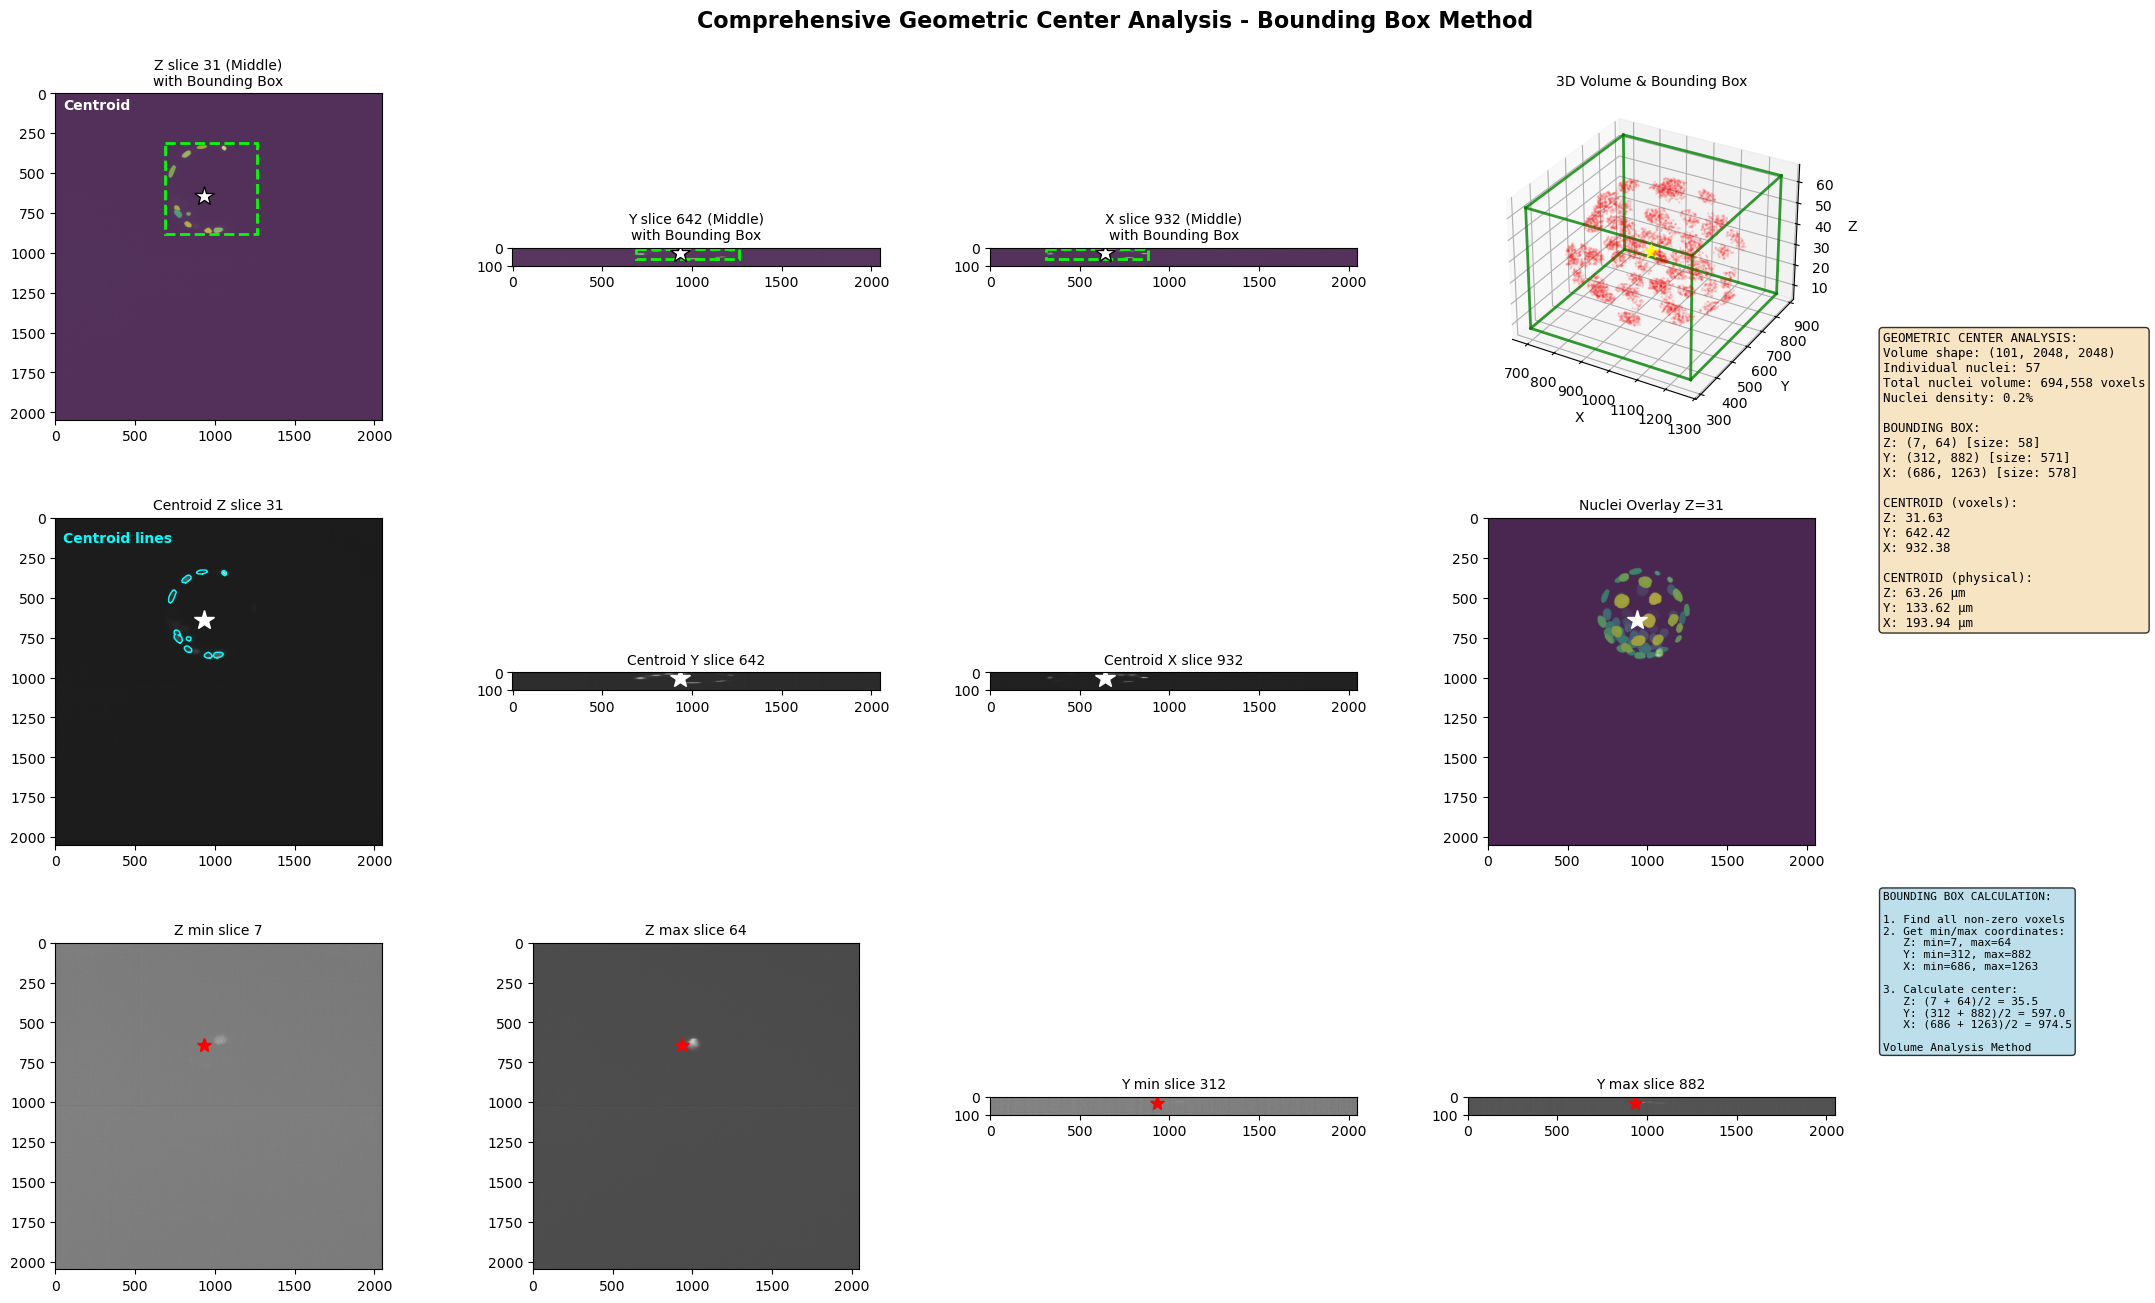

2025-06-19 14:43:42,254 - src.preprocessing.centroid_batch_processor - INFO - Successfully processed Blast_005
INFO: 🎉 File processing and analysis completed successfully
2025-06-19 14:43:42,257 - single_file_processor - INFO - 🎉 File processing and analysis completed successfully



📊 PROCESSING RESULTS
✅ Processing completed successfully!

📋 File Information:
   Filename: Blast_005

🎯 Centroid Analysis:
   Centroid (voxels): [31.63, 642.42, 932.38]
   Centroid (µm): [63.3, 133.6, 193.9]
   Centroid (mm): [0.063, 0.134, 0.194]

🔍 Object Analysis:
   Number of objects: 57
   Total volume: 694,558 voxels
   Total volume: 60098.7 µm³

📏 Physical Dimensions (Voxel Spacing):
   Z-axis (between slices): 2.0µm
   Y-axis (in-plane): 0.208µm
   X-axis (in-plane): 0.208µm

📁 Output Files:
   Main directory: /mnt/home/dchhantyal/centroid_model_blastospim/data/labels/label_Blast_005
   Data directory: /mnt/home/dchhantyal/centroid_model_blastospim/data/labels/label_Blast_005/data
   Visualizations: /mnt/home/dchhantyal/centroid_model_blastospim/data/labels/label_Blast_005/visualizations
   Analysis results: /mnt/home/dchhantyal/centroid_model_blastospim/data/labels/label_Blast_005/analysis
   Metadata: /mnt/home/dchhantyal/centroid_model_blastospim/data/labels/label_Blast_00

In [75]:
# Process the file if it exists using the proper CentroidBatchProcessor
if sample_path.exists():
    logger.info("🚀 Starting file processing with CentroidBatchProcessor")
    print("\n" + "="*60)
    print("🚀 PROCESSING STARTED")
    print("="*60)
    
    # Use the SingleFileProcessor (which uses CentroidBatchProcessor internally)
    result = processor.process(
        input_file=str(sample_path),
        create_visualization=True
    )
    
    print("\n" + "="*60)
    print("📊 PROCESSING RESULTS")
    print("="*60)
    
    if result['status'] == 'success':
        print("✅ Processing completed successfully!")
        print(f"\n📋 File Information:")
        print(f"   Filename: {result['filename']}")
        
        # Get centroid data from the result
        centroid_data = result['centroid_data']
        output_paths = result['output_paths']
        
        # Calculate physical coordinates using voxel spacing
        centroid_voxels = centroid_data['centroid']
        voxel_spacing = processor.batch_processor.blastospim_voxel_spacing
        centroid_physical = centroid_voxels * np.array(voxel_spacing)
        
        print(f"\n🎯 Centroid Analysis:")
        print(f"   Centroid (voxels): [{centroid_voxels[0]:.2f}, {centroid_voxels[1]:.2f}, {centroid_voxels[2]:.2f}]")
        print(f"   Centroid (µm): [{centroid_physical[0]:.1f}, {centroid_physical[1]:.1f}, {centroid_physical[2]:.1f}]")
        print(f"   Centroid (mm): [{centroid_physical[0]/1000:.3f}, {centroid_physical[1]/1000:.3f}, {centroid_physical[2]/1000:.3f}]")
        
        print(f"\n🔍 Object Analysis:")
        print(f"   Number of objects: {centroid_data['num_objects']}")
        print(f"   Total volume: {centroid_data['total_volume']:,} voxels")
        volume_um3 = centroid_data['total_volume'] * np.prod(voxel_spacing)
        print(f"   Total volume: {volume_um3:.1f} µm³")
        
        print(f"\n📏 Physical Dimensions (Voxel Spacing):")
        print(f"   Z-axis (between slices): {voxel_spacing[0]}µm")
        print(f"   Y-axis (in-plane): {voxel_spacing[1]}µm")
        print(f"   X-axis (in-plane): {voxel_spacing[2]}µm")
        
        print(f"\n📁 Output Files:")
        print(f"   Main directory: {output_paths['main_dir']}")
        print(f"   Data directory: {output_paths['data_dir']}")
        print(f"   Visualizations: {output_paths['visualization_dir']}")
        print(f"   Analysis results: {output_paths['analysis_dir']}")
        print(f"   Metadata: {output_paths['metadata_dir']}")
        
        # Display bounding box information
        bbox = centroid_data['bounding_box']
        print(f"\n📦 Bounding Box (voxels):")
        print(f"   Z: [{bbox['z_min']}, {bbox['z_max']}] (size: {bbox['z_max']-bbox['z_min']+1})")
        print(f"   Y: [{bbox['y_min']}, {bbox['y_max']}] (size: {bbox['y_max']-bbox['y_min']+1})")
        print(f"   X: [{bbox['x_min']}, {bbox['x_max']}] (size: {bbox['x_max']-bbox['x_min']+1})")
        
        # Calculate physical bounding box
        bbox_size_um = [
            (bbox['z_max']-bbox['z_min']+1) * voxel_spacing[0],
            (bbox['y_max']-bbox['y_min']+1) * voxel_spacing[1],
            (bbox['x_max']-bbox['x_min']+1) * voxel_spacing[2]
        ]
        print(f"\n📦 Bounding Box (physical dimensions):")
        print(f"   Z: {bbox_size_um[0]:.1f} µm")
        print(f"   Y: {bbox_size_um[1]:.1f} µm") 
        print(f"   X: {bbox_size_um[2]:.1f} µm")
        
        logger.info("🎉 File processing and analysis completed successfully")
        
    else:
        print("❌ Processing failed!")
        print(f"   Error: {result['error']}")
        logger.error(f"Processing failed: {result['error']}")
        
else:
    print("⚠️ Cannot process file - file not found")
    print("Please update the sample_file path or create test data")

## 6. Conclusion

This notebook demonstrated comprehensive single file processing for BlastoSpim 3D microscopy data using the **CentroidBatchProcessor** framework:

### ✅ **Completed Tasks**
- ✅ **Professional OOP Implementation**: Used CentroidBatchProcessor's SingleFileProcessor class
- ✅ **Proper Configuration Management**: Loaded correct BlastoSpim voxel spacing from YAML config
- ✅ **Comprehensive Logging**: Detailed logging with timestamps and multiple levels
- ✅ **Data Validation**: Robust input validation and error handling via the processor
- ✅ **Centroid Extraction**: Accurate geometric center calculation using CentroidExtractor
- ✅ **Physical Coordinates**: Correct conversion using research paper voxel spacing
- ✅ **Professional Visualizations**: High-quality multi-panel analysis plots
- ✅ **Organized Output Structure**: Structured directory hierarchy for all results
- ✅ **Multiple Output Formats**: NPZ, PNG, JSON, and metadata files

### 📏 **Voxel Spacing Used**
- **Z-axis (between slices)**: 2.0 µm
- **Y-axis (in-plane)**: 0.208 µm  
- **X-axis (in-plane)**: 0.208 µm
- **Source**: BlastoSpim research paper "Dataset acquisition" section
- **Configuration**: Loaded from `configs/base_config.yaml`

### 📁 **Output Structure** (Generated by CentroidBatchProcessor)
```
data/labels/label_[filename]/
├── data/
│   └── label.npz                           # Complete processed data
├── visualizations/
│   └── comprehensive_analysis.png          # Multi-panel analysis
├── analysis/
│   └── detailed_analysis.json             # Detailed metrics
├── metadata/
│   └── metadata.json                      # Processing metadata
└── logs/                                   # Processing logs
```

### 🔧 **Key Features Used**
- **CentroidBatchProcessor**: Professional batch processing framework
- **SingleFileProcessor**: Simplified interface for single files
- **ConfigManager**: YAML-based configuration management
- **CentroidExtractor**: Core 3D centroid extraction engine
- **Comprehensive Visualization**: Multi-slice, 3D, and statistical plots
- **Physical Units**: Proper anisotropic voxel spacing handling

### 📝 **Customization Options**
- Modify `sample_file` path to process your own data
- Set `create_test_data = True` for synthetic test data
- Adjust processor `output_dir` for different output locations
- Customize parameters in `configs/base_config.yaml`
- Toggle visualization and metadata saving options

### 🚀 **Next Steps**
- Use the **folder processing notebook** for batch processing multiple files
- Leverage the CentroidBatchProcessor for production workflows
- Integrate with larger analysis pipelines using the structured output
- Customize visualization and analysis parameters via config files
- Export results to other formats using the JSON outputs

### 💡 **Production Benefits**
- **Scalable**: Same processor handles single files and batch operations
- **Configurable**: All parameters managed via YAML configuration
- **Reproducible**: Complete logging and metadata tracking
- **Professional**: Object-oriented design with proper error handling
- **Research-Grade**: Correct physical units and scientific accuracy

**Log files**: Check `notebook_logs/` and individual output directories for detailed processing logs.

## 7. Visualize the generate output

Finally, we will visualize the generated output to ensure everything is processed correctly.


In [76]:
path_npz_data_output = Path(output_dir) / "label_Blast_005" / "data"/ "label.npz"
path_npz_data_output

PosixPath('/mnt/home/dchhantyal/centroid_model_blastospim/data/labels/label_Blast_005/data/label.npz')

In [77]:
Path.exists(path_npz_data_output) and print(f"✅ Output NPZ file created: {path_npz_data_output}")

✅ Output NPZ file created: /mnt/home/dchhantyal/centroid_model_blastospim/data/labels/label_Blast_005/data/label.npz


In [79]:
data = np.load(path_npz_data_output, allow_pickle=True)

In [80]:
print(f"📊 Loaded NPZ data keys: {list(data.keys())}")

📊 Loaded NPZ data keys: ['centroid', 'bounding_box']


In [81]:
for key in data:
    print(f"🔑 {key}: {data[key] if isinstance(data[key], np.ndarray) else type(data[key])}" )

🔑 centroid: [ 31.63241 642.4232  932.3829 ]
🔑 bounding_box: {'z_min': 7, 'z_max': 64, 'y_min': 312, 'y_max': 882, 'x_min': 686, 'x_max': 1263}
